In [19]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.fft import rfft, rfftfreq
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import os
import pickle

from helper_funcs import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# LOAD DATA
# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)
rng = np.random.default_rng()
f = rfftfreq(32768, 1/44100)[0:8192]
spectra = df['spectrum'].to_list()
species_list = df['species'].to_list()
filepaths = df['filepath'].to_list()


In [ ]:
# Test synthetic spectra
i = rng.integers(0, len(spectra))
species = 'Human'
while species_list[i] != species:
    i = rng.integers(0, len(spectra))
# i = 1795
print(i)
# species = 'General'

d = synthesize_spectrum(spectra[i], f=f, species=species, filepath=filepaths[i], plot=True, noise_domain='linear')


Generating Human 0
[]
Generating Human 1
[ 812.87841797 2072.57080078 2255.60302734 3566.43676758 5075.10681152]
Generating Human 2
[ 819.60754395 1643.25256348 1816.86401367 2219.26574707 3666.02783203]
Generating Human 3
[3155.96008301 8400.64086914]
Generating Human 4
[2240.7989502  4984.93652344 6040.06347656]
Generating Human 5
[ 650.03356934 1164.13879395 2460.16845703 2567.83447266 5205.65185547]
Generating Human 6
[ 596.20056152 2532.84301758 6507.06481934]
Generating Human 7
[1395.62072754 1837.0513916  2016.04614258 2322.89428711 3045.60241699]
Generating Human 8


KeyboardInterrupt: 

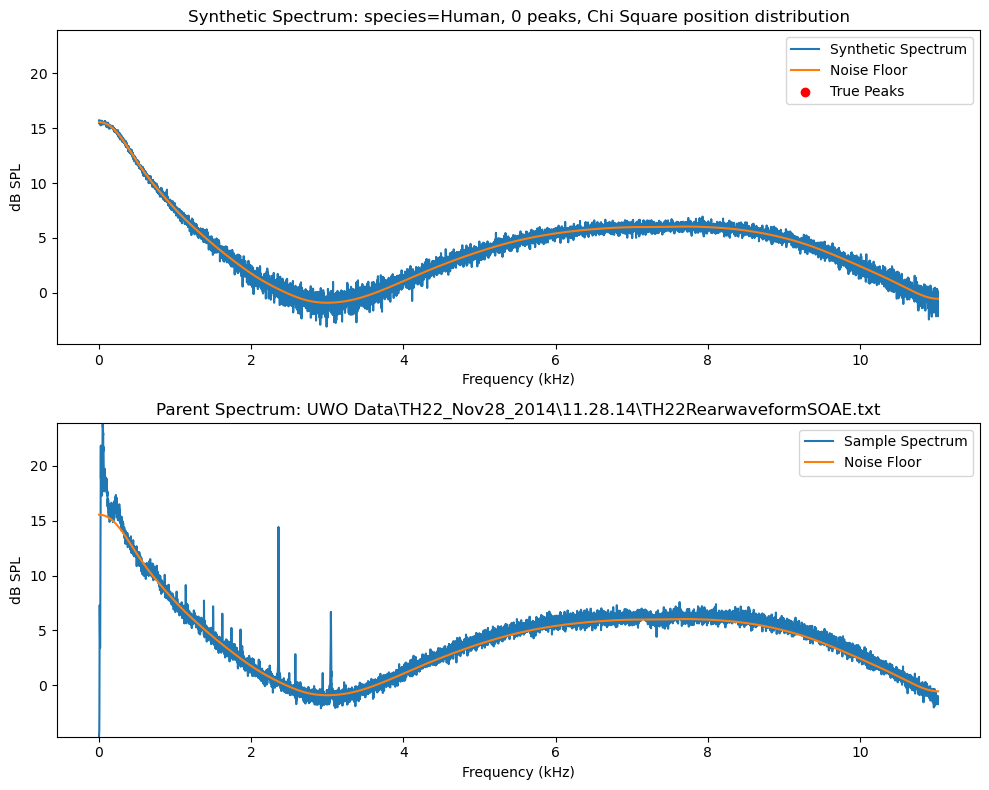

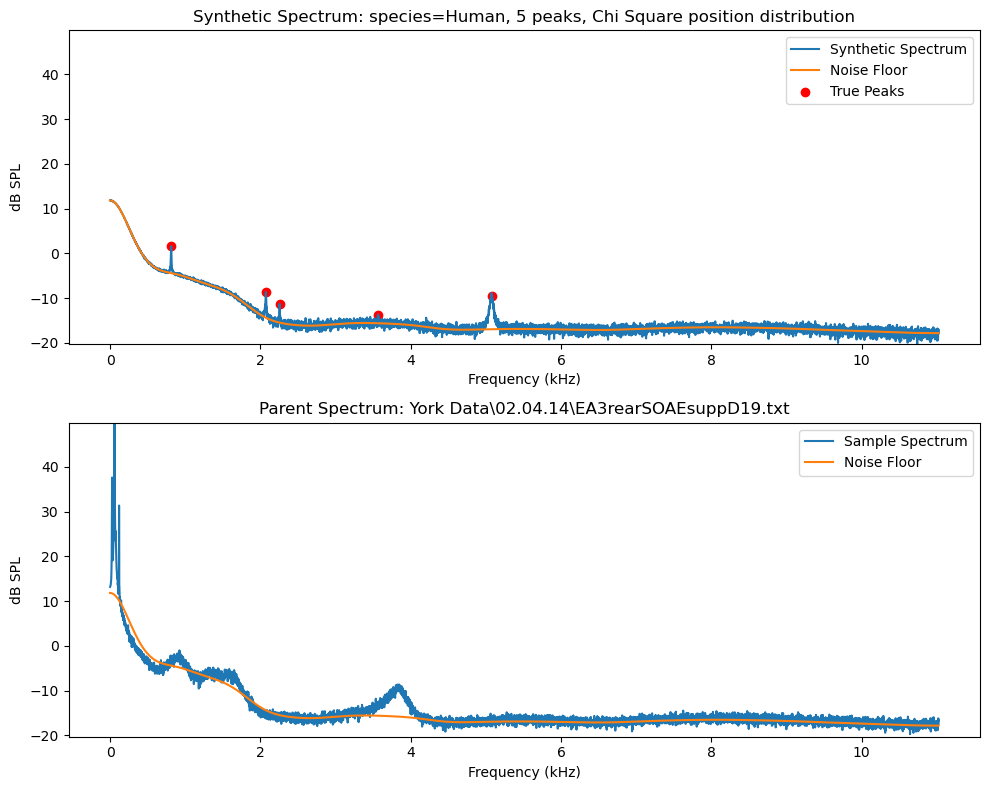

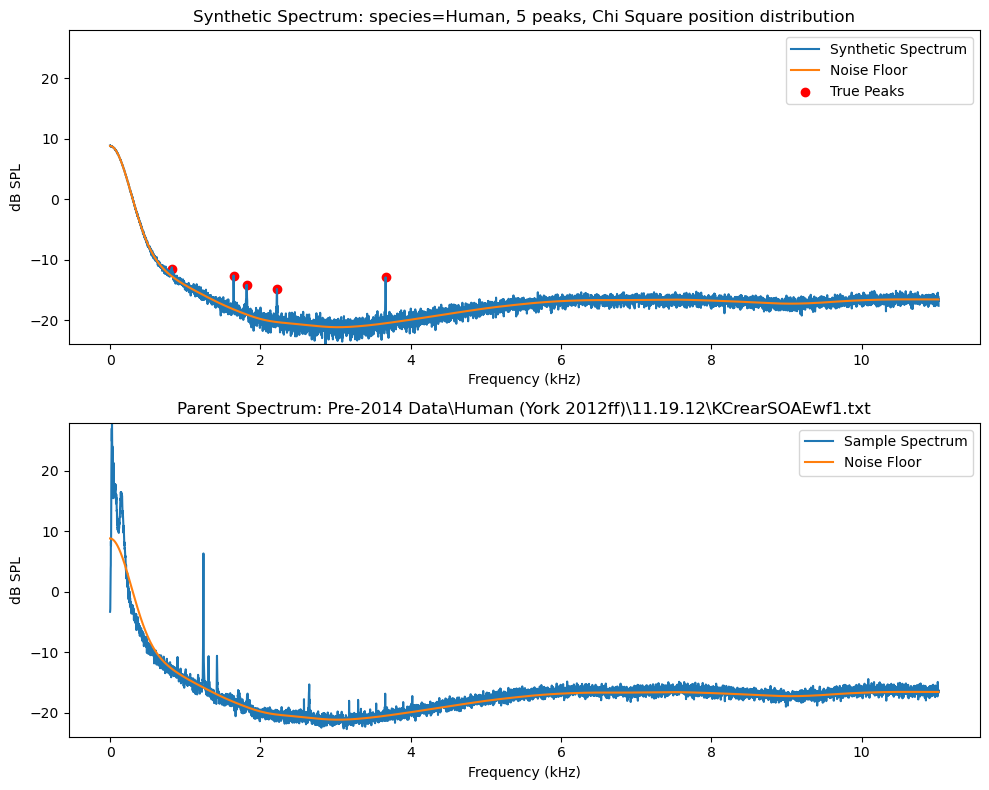

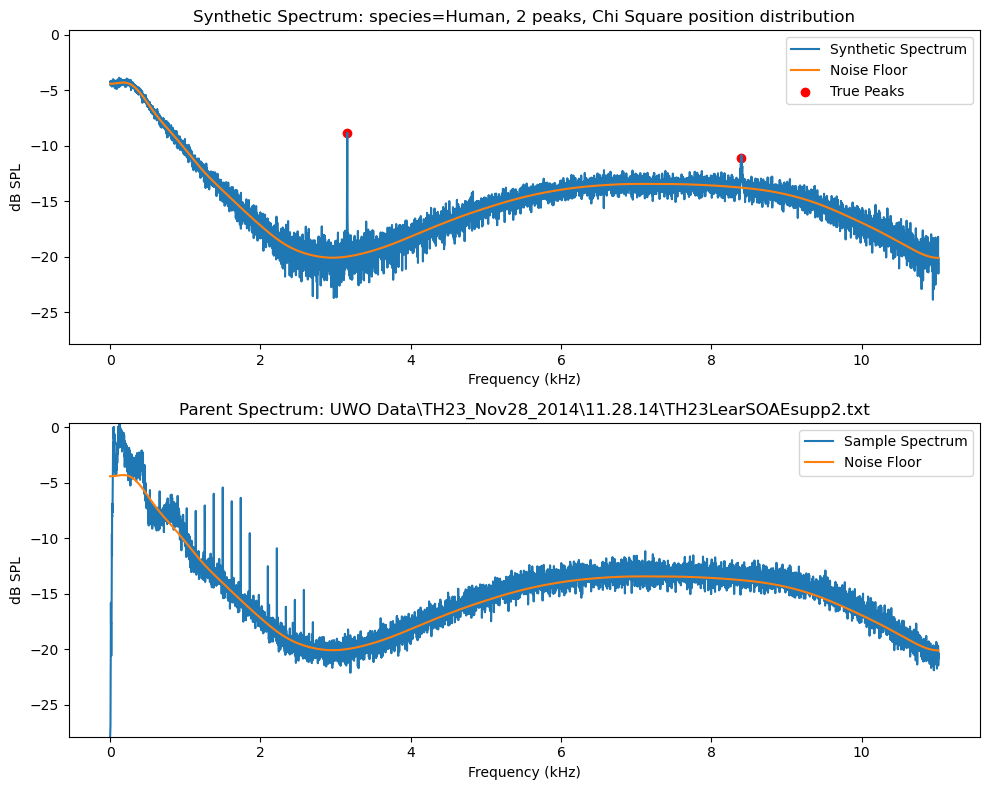

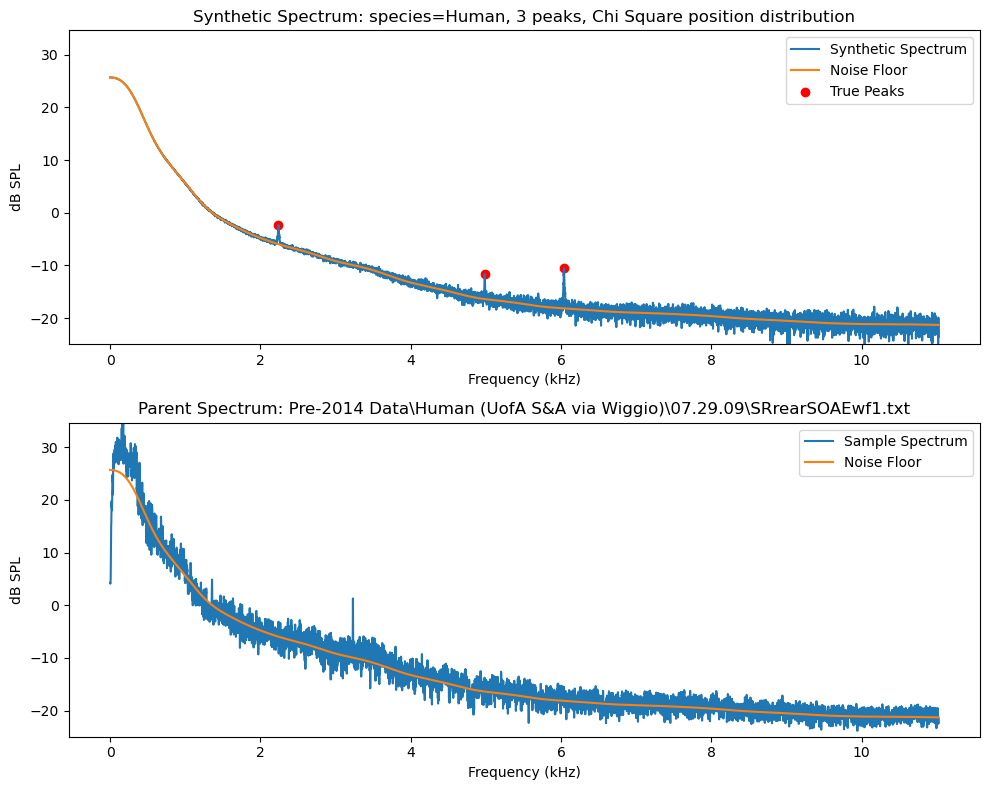

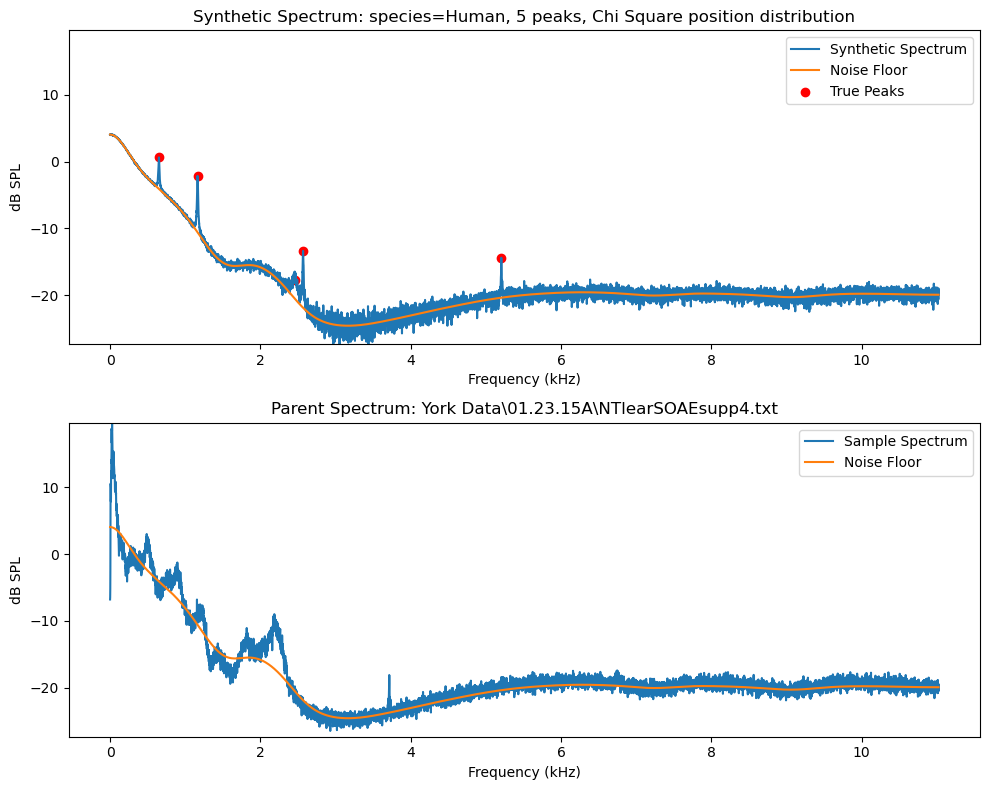

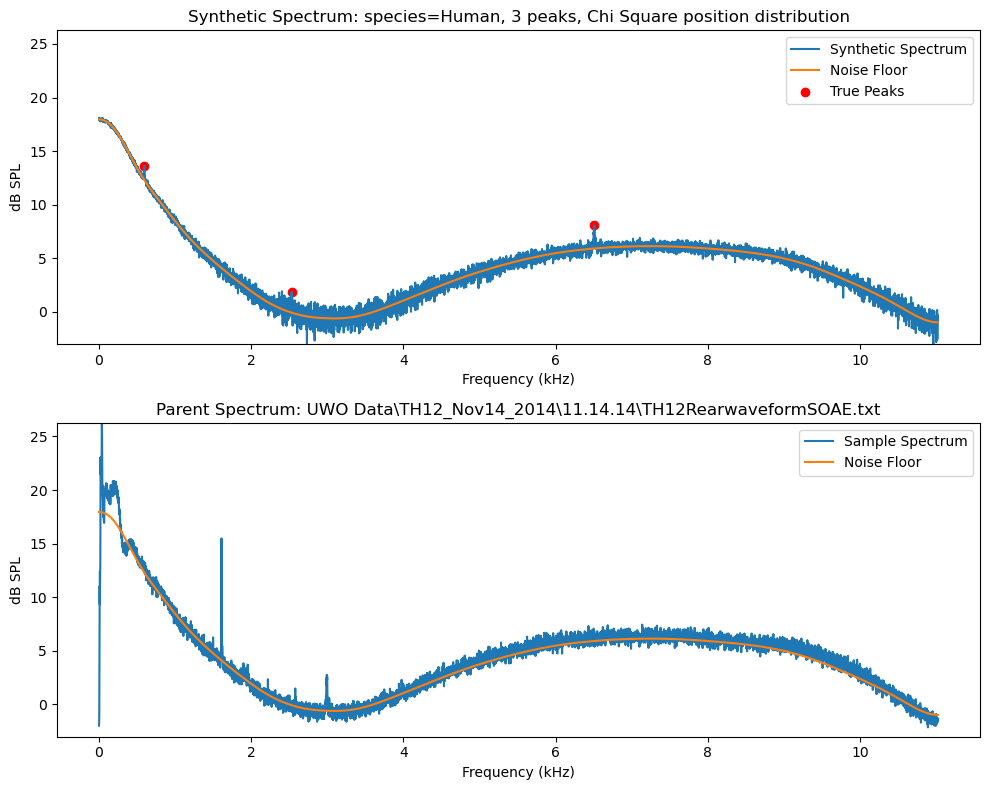

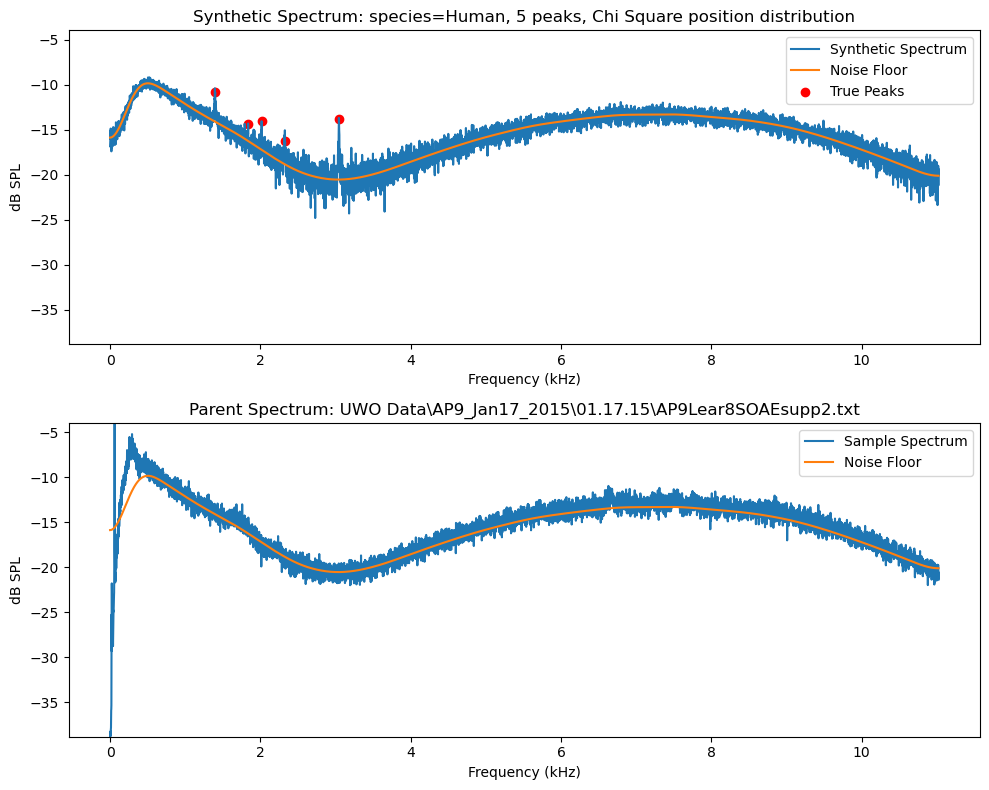

In [22]:
# Generate Synthetic Spectra for Chris Inspection
for species in ['Human', 'Lizard']:
    for j in range(50):
        print(f"Generating {species} {j}")
        i = rng.integers(0, len(spectra))
        while species_list[i] != species:
            i = rng.integers(0, len(spectra))
        save_name = f"{species} {j}.png"
        d = synthesize_spectrum(spectra[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name=save_name, noise_domain='linear')
        
# General
species = 'General'
for j in range(50):
    print(f"Generating {species} {j}")
    i = rng.integers(0, len(spectra))
    save_name = f"{species} {j}.png"
    d = synthesize_spectrum(spectra[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name=save_name, noise_domain='linear')

# dB Scale Noise
for species in ['Human', 'Lizard']:
    for j in range(20):
        print(f"Generating dB {species} {j}")
        i = rng.integers(0, len(spectra))
        while species_list[i] != species:
            i = rng.integers(0, len(spectra))
        save_name = f"dB Scale Noise {species} {j}.png"
        d = synthesize_spectrum(spectra[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name=save_name, noise_domain='log')
species = 'General'
for j in range(20):
    print(f"Generating dB {species} {j}")
    i = rng.integers(0, len(spectra))
    save_name = f"dB Scale Noise {species} {j}.png"
    d = synthesize_spectrum(spectra[i], f=f, species=species, filepath=filepaths[i], plot=True, save_name=save_name, noise_domain='log')

In [ ]:
# Make the transfer dataset
rows = []
i=0
for spectrum, species, filepath in zip(spectra, species_list, filepaths):
    i += 1
    print(f"Synthesizing {i} / {len(spectra)}")
    d = synthesize_spectrum(spectrum, f=f, species=species, filepath=filepath, noise_domain='log')
    rows.append(d)
    if i == 10:
        break
synth_transfer_df = pd.DataFrame(rows)
synth_transfer_df.to_parquet("synth_transfer_df.parquet", engine='pyarrow')

In [ ]:
# Make the general dataset
rows = []
i = 0
for spectrum, species, filepath in zip(spectra, species_list, filepaths):
    i += 1
    print(f"Synthesizing {i} / {len(spectra)}")
    d = synthesize_spectrum(spectrum, f=f, species='General', filepath=filepath, noise_domain='log')
    rows.append(d)
synth_general_df = pd.DataFrame(rows)
synth_general_df.to_parquet("synth_general_df.parquet", engine='pyarrow')

In [ ]:


transfer_samples = gen_samples(df=synth_transfer_df)
general_samples = gen_samples(df=synth_general_df)
samples = np.concatenate((transfer_samples, general_samples), axis=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the chi-square distribution
chi_dof = 11 # Degrees of freedom (k)
chi_og_pivot = 20
chi_new_pivot = 17

# Generate samples from a chi-square distribution
num_samples = 10000  # Number of samples to generate
chi_square_samples_unscaled = np.random.chisquare(df=chi_dof, size=num_samples)  # Unscaled
chi_square_samples_scaled = chi_square_samples_unscaled * chi_new_pivot / chi_og_pivot  # Scaled

# Create subplots for unscaled and scaled distributions
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the unscaled chi-square distribution
axs[0].hist(chi_square_samples_unscaled, bins=50, density=True, alpha=0.7, color='blue', edgecolor='black')
axs[0].set_title(f'Unscaled Chi-Square Distribution (k={chi_dof})')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')
axs[0].grid(True)

# Plot the scaled chi-square distribution
axs[1].hist(chi_square_samples_scaled, bins=50, density=True, alpha=0.7, color='green', edgecolor='black')
axs[1].set_title(f'Scaled Chi-Square Distribution (k={chi_dof})')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')
axs[1].grid(True)

# Adjust layout and show plots
plt.tight_layout()
plt.show()


In [ ]:
# VISUALIZE LORENTZIAN
f = rfftfreq(32768, 1/44100)
f0 = f[5000]
snr = 20
hwhm = 1

plt.plot(f, lorentzian(f, f0, hwhm, snr))
plt.plot(f, np.ones(len(f)) * 10)
plt.xlim(f0-2, f0+2)
plt.show()

In [ ]:
# VISUALIZE NOISE FLOOR
# Get frequency axis
f = rfftfreq(32768, 1/44100)[0:8192]

# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)

df = df[df['filepath'].str.contains("UWO Data")]
df = df[df['filepath'].str.contains("waveform")]
df = df.sample(frac=1).reset_index(drop=True)
spectrums = df['spectrum'].to_list()
filepaths = df['filepath'].to_list()
species = df['species'].to_list()

In [ ]:
frac_broad= 0.3
smoothing_sigma = 150
fit_close_cutoff = 300

i = 0

for spectrum, filepath in zip(spectrums, filepaths):
    i+=1
    if i > 10:
        break
    
    
    noise_floor = get_noise_floor(f, spectrum)
    plt.plot(f, spectrum, label='Original Spectrum')
    # plt.plot(f, min_spectrum, 'black', label='min_spectrum')
    # plt.plot(f, fit_broad,'g--',label='Broad LOWESS Fit')
    # plt.plot(f, fit_close,'r--',label='Close LOWESS Fit')
    plt.plot(f, noise_floor,'black',label='Noise Floor')
    plt.legend()
    plt.title(filepath)
    plt.savefig(filepath + ".png")
    plt.show()
    

In [ ]:
# Finding noise distribution


# First navigate to our directory
directory_path = os.path.join("Data", "processed_df.parquet")
# Load the dataframe
df = pd.read_parquet(directory_path)
# Get frequncy axis
f = rfftfreq(32768, 1/44100)[0:8192]


In [ ]:
f = rfftfreq(32768, 1/44100)[0:8192]
index = 2000
spectrum = df.iloc[index]['spectrum']
filepath = df.iloc[index]['filepath']
# Cut this off to 8000 and 11000
f_min = np.argmin(np.abs(f - 8000))
f_max = np.argmin(np.abs(f - 11000))
f = f[f_min:f_max]
spectrum = spectrum[f_min:f_max]

linear_spectrum = 10**(spectrum/20)
lowess = sm.nonparametric.lowess
frac = 0.1
linear_lowess_fit = lowess(linear_spectrum, f, frac=frac, return_sorted=False)
linear_noise = linear_spectrum - linear_lowess_fit

# Fit a normal distribution to the data using MLE
std = np.sqrt(np.mean((linear_noise)**2))
mean = 0

# Generate normal distribution curve
x = np.linspace(min(linear_noise), max(linear_noise), 1000)
pdf = norm.pdf(x, mean, std)

# PLOT
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Create 1 row, 2 columns of subplots

# Plot One: Noise floor and spectrum
axes[0].plot(f, linear_spectrum, label="Spectrum (Linear Scale)")
axes[0].plot(f, linear_lowess_fit, label=f"Estimated Noise Floor (LOWESS fit, frac={frac})")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Spectral Magnitudes (Linear)")
axes[0].set_title("Peakless Region of Spectrum")
axes[0].legend()

# Plot Two: Histogram of linear noise
axes[1].hist(linear_noise, bins=100, density=True, color='blue', alpha=0.6, label='Noise (Spectrum - Noise Floor)', edgecolor='black')
axes[1].plot(x, pdf, color='red', linewidth=2, label=f'Normal Fit: $\mu=0$, $\sigma={np.round(std, 5)}$')
axes[1].set_title("Density Histogram of Noise Distribution")
axes[1].set_xlabel("Noise Amplitude")
axes[1].set_ylabel("Density")
axes[1].legend()

# Add a shared title for the entire figure
fig.suptitle("Estimation of Additive Noise", fontsize=14)

# Adjust layout to avoid overlapping elements
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plots
plt.show()



In [ ]:
db_lowess_fit = lowess(spectrum, f, frac=frac, return_sorted=False)
linear_noise = linear_spectrum - linear_lowess_fit
db_noise = spectrum - db_lowess_fit
# Histogram for linear noise

# Fit a normal distribution to the data using MLE
mean, std = norm.fit(linear_noise)
print(mean)

# Generate points for the normal distribution curve
x = np.linspace(min(linear_noise), max(linear_noise), 1000)
pdf = norm.pdf(x, mean, std)

# Plot the histogram
plt.hist(linear_noise, bins=100, density=True, color='blue', alpha=0.6, label='Data', edgecolor='black')

# Plot the normal distribution curve
plt.plot(x, pdf, color='red', linewidth=2, label='Normal Fit')

plt.title("Linear Noise")

plt.show()

# # Histogram for dB noise

# # Fit a normal distribution to the data
# mean, std = norm.fit(db_noise)
# print(mean)

# # Generate points for the normal distribution curve
# x = np.linspace(min(db_noise), max(db_noise), 1000)
# pdf = norm.pdf(x, mean, std)

# # Plot the histogram
# plt.hist(db_noise, bins=100, density=True, color='blue', alpha=0.6, label='Data', edgecolor='black')

# # Plot the normal distribution curve
# plt.plot(x, pdf, color='red', linewidth=2, label='Normal Fit')

# plt.title("dB Noise")

# plt.show()

In [ ]:
# Get sigmas
sigmas = np.empty(len(spectra))
for i, spectrum in enumerate(spectra):
    sigmas[i] = estimate_noise_sigma(spectrum, f=f, noise_domain='log')
    print(f"Processing {i}/{len(spectra)}")

sigmas_df = pd.DataFrame(sigmas, columns=['Sigma'])
sigmas_df.to_parquet('sigmas.parquet')    
    

In [ ]:
sigmas = pd.read_parquet('sigmas.parquet')['Sigma'].to_list()
plt.hist(sigmas, bins=500, density=True)
plt.show()